<a href="https://colab.research.google.com/github/machiwao/CCTHESS1-CCTHESS2-Dev-and-Docs/blob/eco/ToDrive_NDBaI_data_scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install earthengine-api geemap scipy

In [2]:
import ee
import geemap
import pandas as pd
from scipy.signal import savgol_filter
import os

In [3]:
cloud_project = 'midyear-forest-427007-s7'

try:
  ee.Initialize(project=cloud_project)
except:
  ee.Authenticate()
  ee.Initialize(project=cloud_project)

stations = {
    "PortArea": ee.Geometry.Point([120.967866, 14.58841]).buffer(25000),
    "ScienceGarden": ee.Geometry.Point([121.044282, 14.645072]).buffer(25000),
    "SangleyPoint": ee.Geometry.Point([120.906838, 14.494953]).buffer(25000),
    "PuertoPrinsesa": ee.Geometry.Point([118.758613, 9.740134]).buffer(25000),
    "SanJose": ee.Geometry.Point([121.04788, 12.359602]).buffer(25000),
}

start_date = "2014-01-01"
end_date   = "2024-01-01"


In [4]:
import ee

def get_hls_collection(region, start_date, end_date):
    """
    Get HLS Landsat (HLSL30) collection and compute NDBaI.
    NDBaI = (SWIR - TIR) / (SWIR + TIR)
    Based on Zha et al. (2003), Xu (2008).
    """

    # Landsat-based HLS (HLSL30)
    hls_landsat = (
        ee.ImageCollection("NASA/HLS/HLSL30/v002")
        .filterBounds(region)
        .filterDate(start_date, end_date)
        .map(lambda img: img
             # Select relevant bands
             .select(["B5", "B6"], ["SWIR", "TIR"])  # SWIR1, Thermal IR
             # Apply scale factors
             .multiply(0.0001)
             .copyProperties(img, img.propertyNames()))
    )

    # Compute NDBaI
    def add_ndbai(img):
        ndbai = img.expression(
            "(SWIR - TIR) / (SWIR + TIR)",
            {
                "SWIR": img.select("SWIR"),
                "TIR": img.select("TIR")
            }
        ).rename("NDBaI")
        return img.addBands(ndbai).select("NDBaI")

    return hls_landsat.map(add_ndbai)


In [5]:
import ee
import geemap
import pandas as pd

def process_station(station_name, geometry, start_date, end_date):
    """
    Process HLS Landsat (HLSL30) collection to compute NDBaI time series,
    interpolate missing values, and export to CSV.
    """
    hls = get_hls_collection(geometry, start_date, end_date)

    print(f"Processing NDBaI for {station_name}...")

    # Extract mean NDBaI for each image
    ts = hls.map(lambda img: ee.Feature(
        None, {
            "date": img.date().format("YYYY-MM-dd"),
            "NDBaI": img.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=geometry,
                scale=30,
                bestEffort=True,
                maxPixels=1e9
            ).get("NDBaI")
        }
    ))

    df = geemap.ee_to_df(ee.FeatureCollection(ts))

    if df.empty:
        print(f"No data for {station_name}")
        return df

    # Process time series
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").groupby("date").mean().reset_index()

    # Reindex to strict daily range
    full_range = pd.date_range(start=start_date, end=end_date, freq="D")
    g = df.set_index("date").reindex(full_range)
    g.index.name = "date"
    g = g.reset_index()

    # Preserve original values
    g["NDBaI_original"] = g["NDBaI"]

    # Interpolation (fill missing only, originals remain intact)
    g["NDBaI_linear"] = g["NDBaI"].interpolate(
        method="linear", limit_direction="both"
    )
    g["NDBaI_spline"] = g["NDBaI"].interpolate(
        method="spline", order=3, limit_direction="both"
    )

    # Save to CSV
    out_file = f"{station_name}_NDBaI.csv"
    g[["date", "NDBaI_original", "NDBaI_linear", "NDBaI_spline"]].to_csv(out_file, index=False)

    print(f"Saved {out_file} ({g.shape[0]} rows)")
    return g

In [6]:
all_dfs = {}
for station, geom in stations.items():
    all_dfs[station] = process_station(station, geom, start_date, end_date)

Processing NDBaI for PortArea...
Saved PortArea_NDBaI.csv (3653 rows)
Processing NDBaI for ScienceGarden...
Saved ScienceGarden_NDBaI.csv (3653 rows)
Processing NDBaI for SangleyPoint...
Saved SangleyPoint_NDBaI.csv (3653 rows)
Processing NDBaI for PuertoPrinsesa...
Saved PuertoPrinsesa_NDBaI.csv (3653 rows)
Processing NDBaI for SanJose...
Saved SanJose_NDBaI.csv (3653 rows)


In [7]:
# Check the first few rows of one of the dataframes
if all_dfs:
    first_station = list(all_dfs.keys())[0]
    print(f"First values for {first_station}:")
    display(all_dfs[first_station].head())
else:
    print("No dataframes were processed.")

First values for PortArea:


,date,NDBaI,NDBaI_original,NDBaI_linear,NDBaI_spline
0,2014-01-01,NaN,NaN,-0.006647,-0.030617
1,2014-01-02,NaN,NaN,-0.006647,-0.030768
2,2014-01-03,NaN,NaN,-0.006647,-0.030919
3,2014-01-04,NaN,NaN,-0.006647,-0.031069
4,2014-01-05,NaN,NaN,-0.006647,-0.031219


Mounted at /content/drive
Saved PortArea_NDBaI.csv to Google Drive


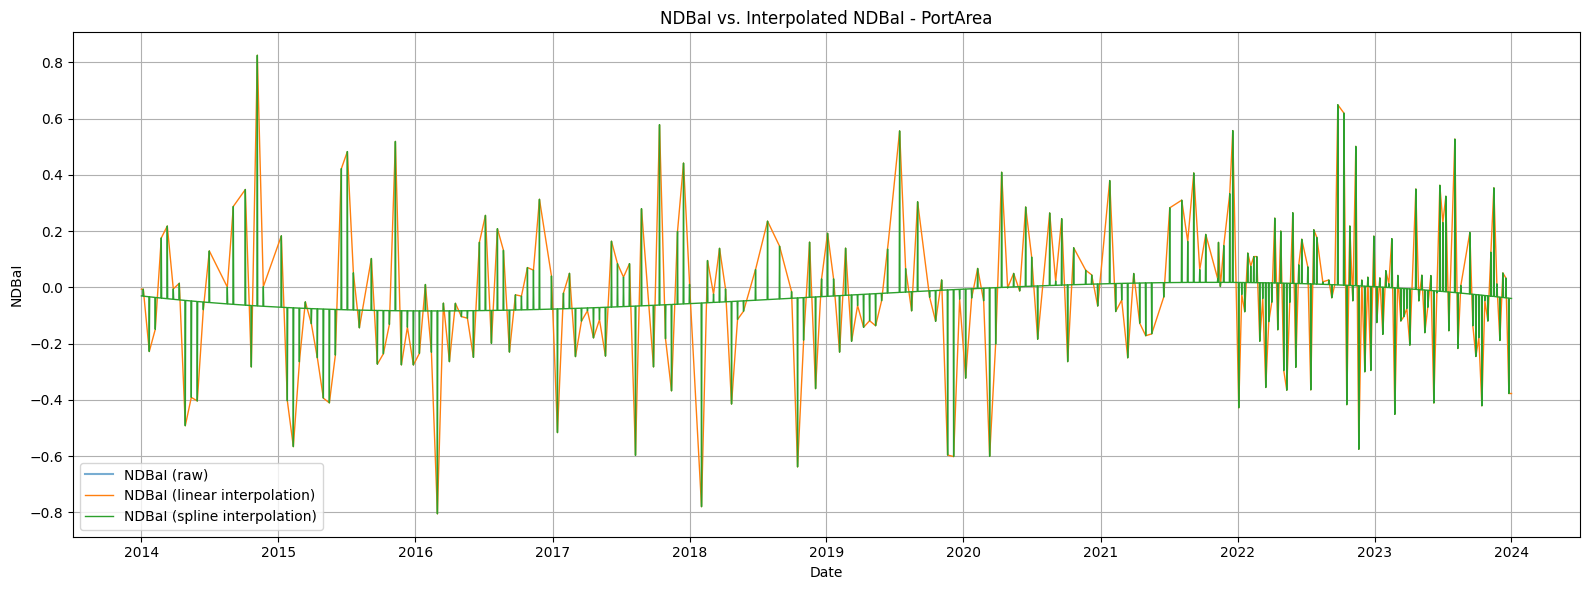

Saved ScienceGarden_NDBaI.csv to Google Drive


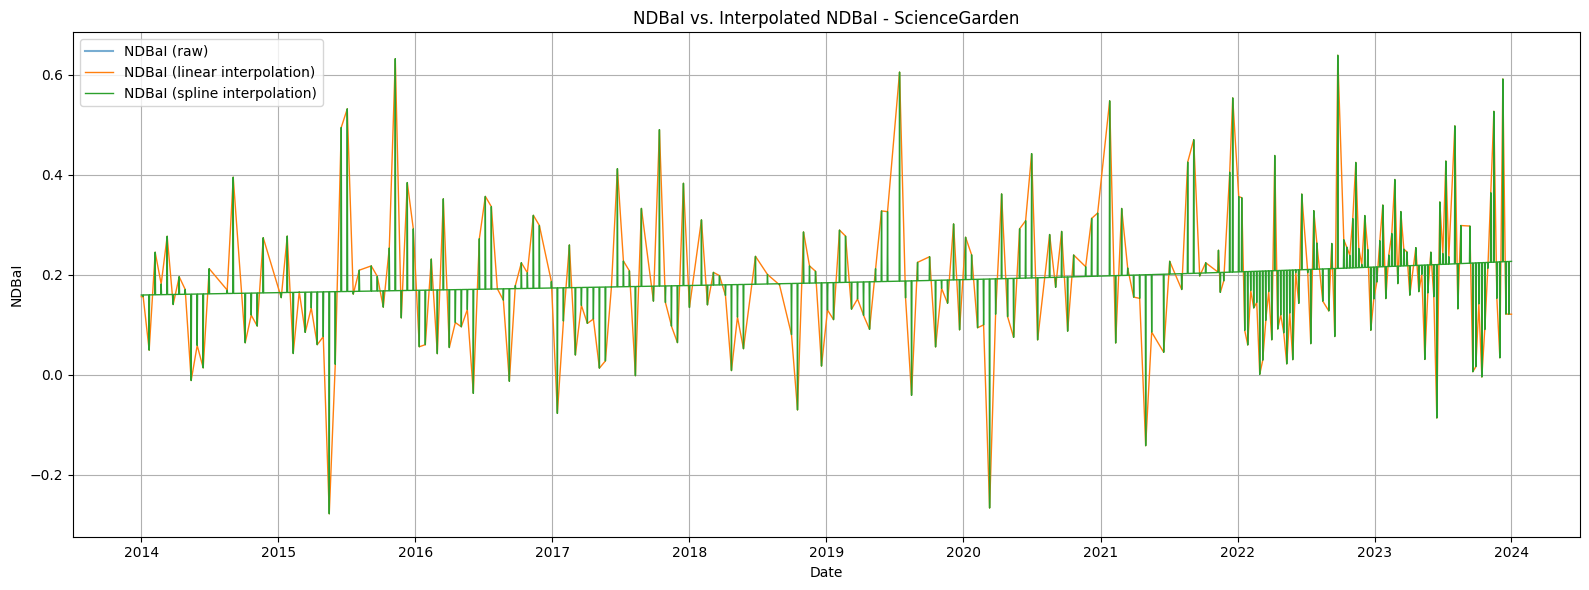

Saved SangleyPoint_NDBaI.csv to Google Drive


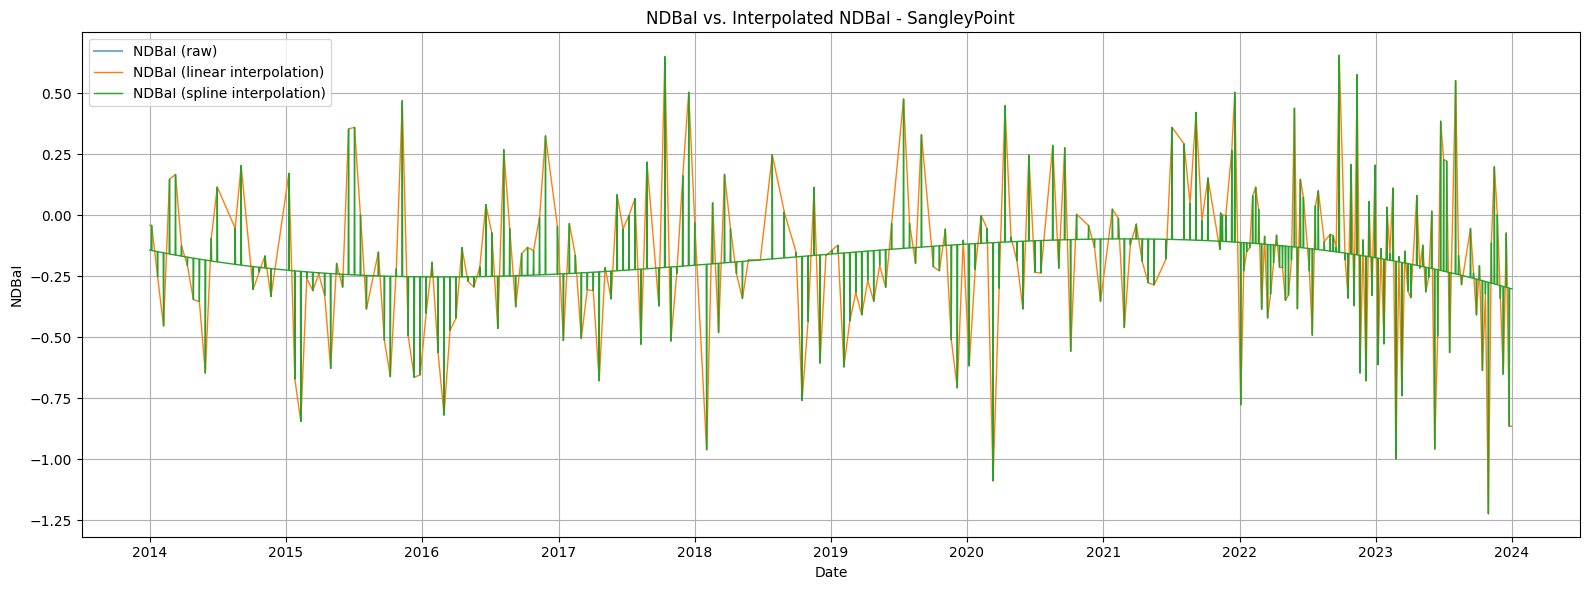

Saved PuertoPrinsesa_NDBaI.csv to Google Drive


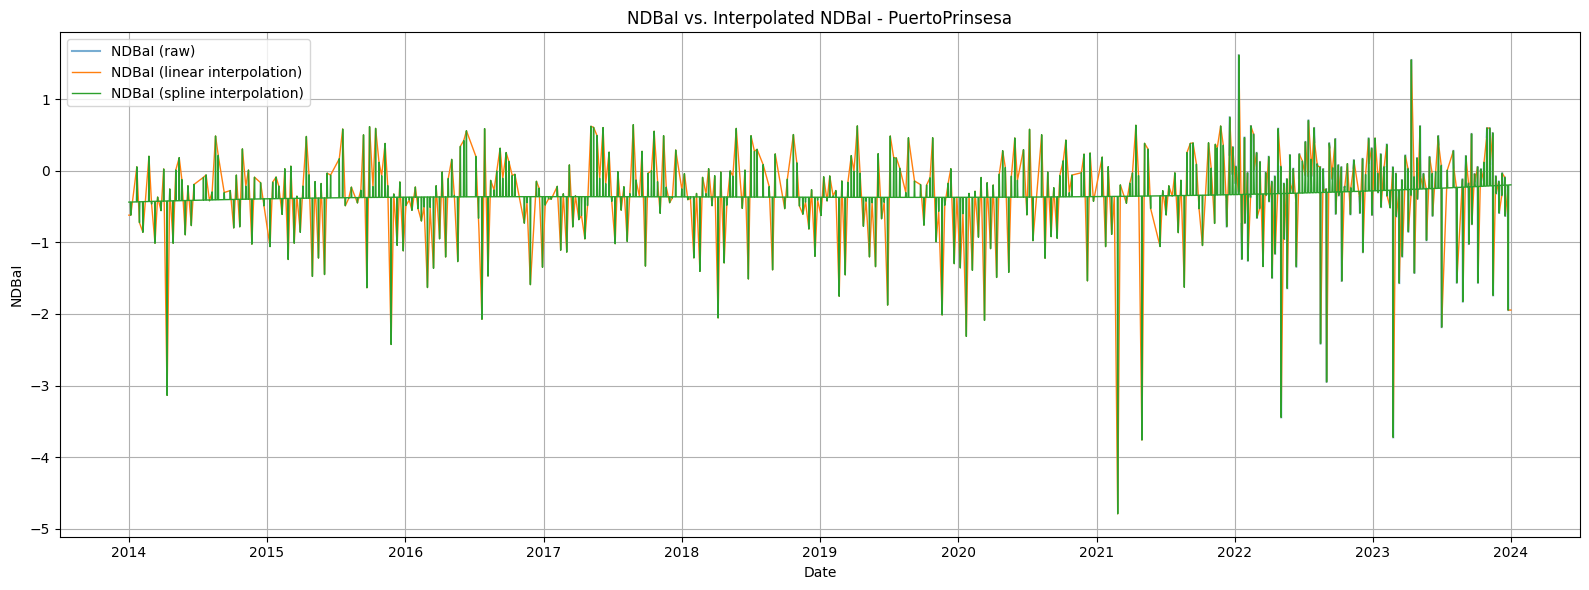

Saved SanJose_NDBaI.csv to Google Drive


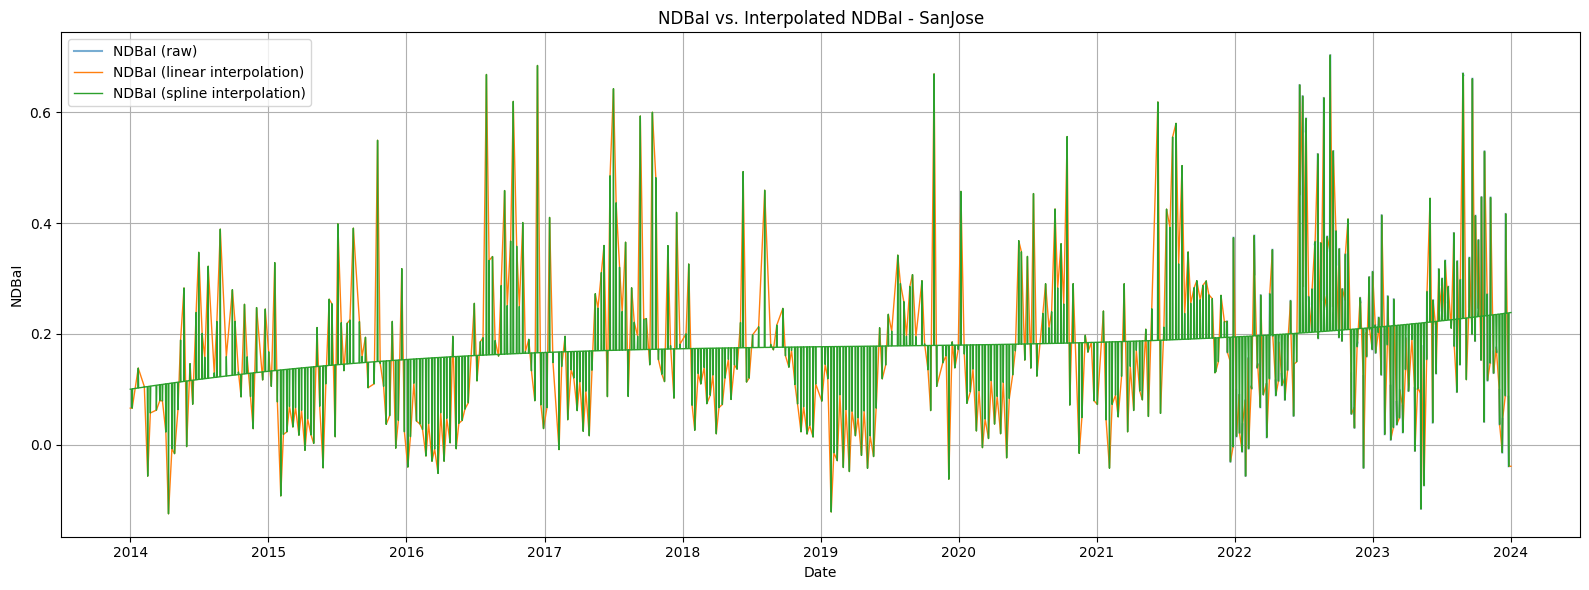

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Create a folder for your CSV files (optional)
output_folder = '/content/drive/MyDrive/Jerico_Datasets/NDBaI'
os.makedirs(output_folder, exist_ok=True)

def plot_values(csv_file, station_name, save_to_drive=True):
    # Load CSV (expects columns: date, NDBI_original, NDBI_linear, NDBI_spline)
    df = pd.read_csv(csv_file, parse_dates=["date"])

    # If saving to drive, copy the file there
    if save_to_drive:
        drive_path = os.path.join(output_folder, f"{station_name}_NDBaI.csv")
        df.to_csv(drive_path, index=False)
        print(f"Saved {station_name}_NDBaI.csv to Google Drive")

    # Plot
    plt.figure(figsize=(16, 6))
    plt.plot(df["date"], df["NDBaI_original"], label="NDBaI (raw)", alpha=0.6)
    plt.plot(df["date"], df["NDBaI_linear"], label="NDBaI (linear interpolation)", linewidth=1)
    plt.plot(df["date"], df["NDBaI_spline"], label="NDBaI (spline interpolation)", linewidth=1)

    plt.xlabel("Date")
    plt.ylabel("NDBaI")
    plt.title(f"NDBaI vs. Interpolated NDBaI - {station_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

station_names = ["PortArea", "ScienceGarden", "SangleyPoint", "PuertoPrinsesa", "SanJose"]
for station in station_names:
    csv_file = f"{station}_NDBaI.csv"
    plot_values(csv_file, station)